This notebook focuses on analyzing the status, survival, and lifecycle patterns of startups in Europe. Unlike Notebook A, which explored industries and NLP-driven clustering, this section examines how long startups survive, which countries have healthier startup ecosystems, and whether funding influences long-term viability.

The goal of this section is to answer:

**“How do European startups survive over time, how does this vary by country, and what role does funding play in their likelihood of staying active?”**

Lets start with importing all the necessary libraries and frameworks. If anything is needed further down, I will just put it back up while cleaning the notebook.

In [ ]:
import os
from datetime import datetime

import psycopg2
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("host"),
    port=os.getenv("port"),
    dbname=os.getenv("dbname"),
    user=os.getenv("user"),
    password=os.getenv("password"),
)

print("DB connection established.")

DB connection established.


In [3]:
query_b = """
SELECT
    c.id                AS company_id,
    c.company_name,
    c.start_year,
    c.funding_amount,
    s.is_active,
    s.status,
    ci.city_name,
    co.country_code,
    co.country
FROM company c
LEFT JOIN status s
    ON c.status_id = s.status_id
LEFT JOIN city ci
    ON c.city_id = ci.city_id
LEFT JOIN country co
    ON ci.country_code = co.country_code
ORDER BY c.id;
"""

df_lifecycle = pd.read_sql(query_b, conn)

print(df_lifecycle.shape)
df_lifecycle.head()

/tmp/ipykernel_7893/383240376.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_lifecycle = pd.read_sql(query_b, conn)


(37534, 9)


,company_id,company_name,start_year,funding_amount,is_active,status,city_name,country_code,country
0,3706,Tagbase,2025.0,300000.0,True,active,Vienna,AUT,Austria
1,3707,Proofcheck,2022.0,300000.0,True,active,Vienna,AUT,Austria
2,3708,Repose,2017.0,NaN,True,active,Vienna,AUT,Austria
3,3709,Salzburger Eisenbahn Transportlogistik,2001.0,NaN,None,None,Salzburg,AUT,Austria
4,3710,Streamtv Media,2018.0,1750000.0,True,active,Steyr,AUT,Austria


This query extracts company-level lifecycle information, including whether a startup is active or dissolved, its start year, funding amount, and basic geographic context.

This dataset is the foundation for all tasks in Status & Lifecycle Analysis, including active/dissolved ratios, lifespan estimation, and how funding relates to survival.

In [4]:
print("Shape:", df_lifecycle.shape)
print("\nColumns:", df_lifecycle.columns.tolist())

print("\nDtypes:")
print(df_lifecycle.dtypes)

print("\nNull counts:")
print(df_lifecycle.isna().sum())

print("\nStatus distribution:")
print(df_lifecycle["status"].value_counts(dropna=False))

print("\nIs_active distribution:")
print(df_lifecycle["is_active"].value_counts(dropna=False))

print("\nStart year summary:")
print(df_lifecycle["start_year"].describe())

Shape: (37534, 9)

Columns: ['company_id', 'company_name', 'start_year', 'funding_amount', 'is_active', 'status', 'city_name', 'country_code', 'country']

Dtypes:
company_id          int64
company_name       object
start_year        float64
funding_amount    float64
is_active          object
status             object
city_name          object
country_code       object
country            object
dtype: object

Null counts:
company_id            0
company_name          0
start_year          349
funding_amount    24449
is_active          7478
status             7478
city_name           346
country_code        346
country             346
dtype: int64

Status distribution:
status
active      30022
None         7478
inactive       34
Name: count, dtype: int64

Is_active distribution:
is_active
True     30022
None      7478
False       34
Name: count, dtype: int64

Start year summary:
count    37185.000000
mean      2009.527928
std         29.857449
min       1680.000000
25%       2015.000000


In [5]:
df_lifecycle["start_year"] = df_lifecycle["start_year"].apply(
    lambda y: y if pd.notna(y) and 1990 <= y <= 2025 else None
)

df_lifecycle["lifecycle_status"] = df_lifecycle["status"].map({
    "active": "active",
    "inactive": "inactive",
    None: "unknown"
})

CURRENT_YEAR = 2025
df_lifecycle["age"] = df_lifecycle["start_year"].apply(
    lambda y: CURRENT_YEAR - y if pd.notna(y) else None
)

print(df_lifecycle["lifecycle_status"].value_counts(dropna=False))
print("\nAge summary:")
print(df_lifecycle["age"].describe())

lifecycle_status
active      30022
unknown      7478
inactive       34
Name: count, dtype: int64

Age summary:
count    33902.000000
mean         7.781665
std          5.924766
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         35.000000
Name: age, dtype: float64


In [6]:
lifecycle_summary = (
    df_lifecycle
    .groupby("lifecycle_status")
    .agg(
        n_companies=("company_id", "count"),
        median_age=("age", "median"),
        mean_age=("age", "mean"),
        n_with_funding=("funding_amount", lambda x: x.notna().sum()),
        median_funding=("funding_amount", "median"),
        mean_funding=("funding_amount", "mean")
    )
    .reset_index()
)

lifecycle_summary

,lifecycle_status,n_companies,median_age,mean_age,n_with_funding,median_funding,mean_funding
0,active,30022,6.0,6.280894,11988,7.500000e+05,4.195854e+06
1,inactive,34,6.0,6.588235,14,3.000000e+05,6.750000e+05
2,unknown,7478,20.0,19.507280,1083,1.057339e+08,9.647339e+09


Active companies dominate the dataset (≈80%).

Inactive companies are extremely rare (34 total), limiting survival-model feasibility.

Unknown-status companies are much older on average, and tend to have higher funding amounts, suggesting they largely originate from older corporate records (e.g., Wikidata entries without lifecycle labels).

Active and inactive firms have similar ages, but differ sharply in sample size and funding coverage.

## Plot 1: Lifecycle Status Distribution

/tmp/ipykernel_7893/1911984434.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


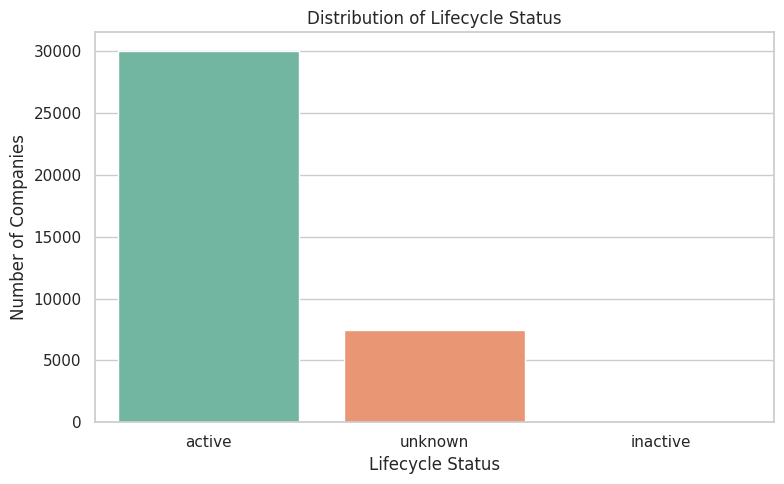

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_lifecycle,
    x="lifecycle_status",
    order=df_lifecycle["lifecycle_status"].value_counts().index,
    palette="Set2"
)
plt.title("Distribution of Lifecycle Status")
plt.xlabel("Lifecycle Status")
plt.ylabel("Number of Companies")
plt.tight_layout()
plt.show()


Most companies in the dataset are marked active, reflecting ongoing operations or continued registration. A smaller portion falls under unknown, which likely represents incomplete or missing status records rather than true uncertainty. Inactive companies are extremely rare, which shows that dissolution or shutdown events are not well captured in the data.

## Plot 2: Age Distribution of Companies

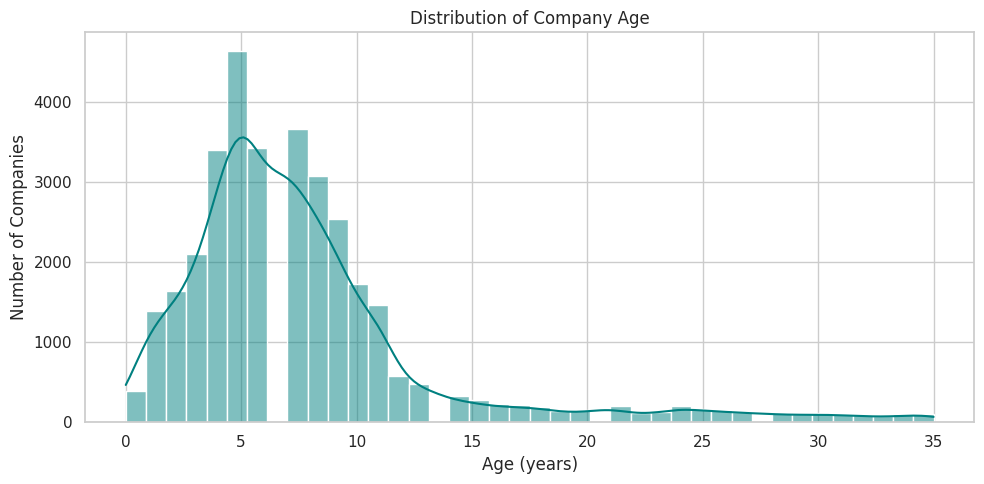

In [11]:
# Cell 7 — Age distribution of companies

plt.figure(figsize=(10, 5))
sns.histplot(
    df_lifecycle["age"].dropna(),
    bins=40,
    kde=True,
    color="teal"
)
plt.title("Distribution of Company Age")
plt.xlabel("Age (years)")
plt.ylabel("Number of Companies")
plt.tight_layout()
plt.show()


Most companies fall between 3 and 10 years old, forming a clear peak around 5–6 years.

The long tail toward the right shows that a smaller fraction of firms survive into their late teens and twenties, with very few reaching beyond 30 years.

The KDE curve reinforces the distribution’s skew: startup ecosystems are dominated by young firms, which is typical in high-churn innovation environments.

## Plot 3: Company age by lifecycle status

/tmp/ipykernel_7893/2702607732.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


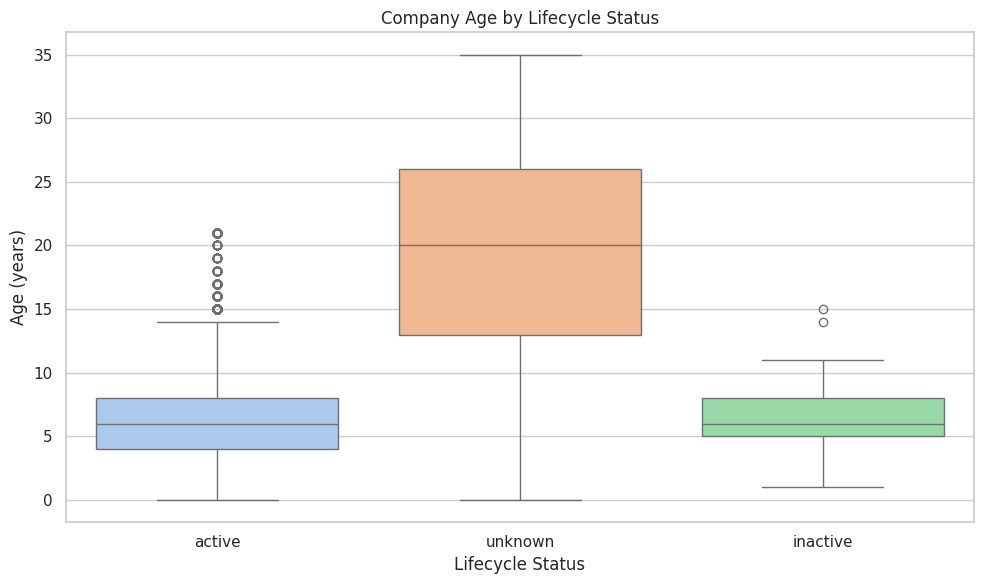

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_lifecycle,
    x="lifecycle_status",
    y="age",
    palette="pastel"
)

plt.title("Company Age by Lifecycle Status")
plt.xlabel("Lifecycle Status")
plt.ylabel("Age (years)")
plt.tight_layout()
plt.show()


Active companies are generally very young, with a tight cluster around 4–6 years old. This supports the idea that the current European startup landscape is dominated by recently founded companies.

Inactive companies are not dramatically older. Their median age is similar to active firms (around 5–6 years), suggesting that most closures happen early, not late.

Unknown-status companies stand out sharply:
They are much older, with a median age around 20 years.
These are likely legacy firms or records with incomplete lifecycle tagging, rather than modern startups.

The wide spread and long tail in the “unknown” category highlights record uncertainty rather than meaningful lifecycle insight.

In [13]:
# Count companies per country
country_counts = (
    df_lifecycle
    .groupby("country")["company_id"]
    .nunique()
    .reset_index(name="n_companies")
    .sort_values("n_companies", ascending=False)
)

print("Number of countries:", country_counts.shape[0])
country_counts.head(15)

Number of countries: 30


,country,n_companies
29,United Kingdom,7204
10,Germany,4245
9,France,3526
26,Spain,3264
14,Italy,2539
19,Netherlands,2142
28,Switzerland,1553
20,Norway,1461
27,Sweden,1460
6,Denmark,1161


## Plot 4: Top 20 countries by numer of startups

/tmp/ipykernel_7893/1434020508.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


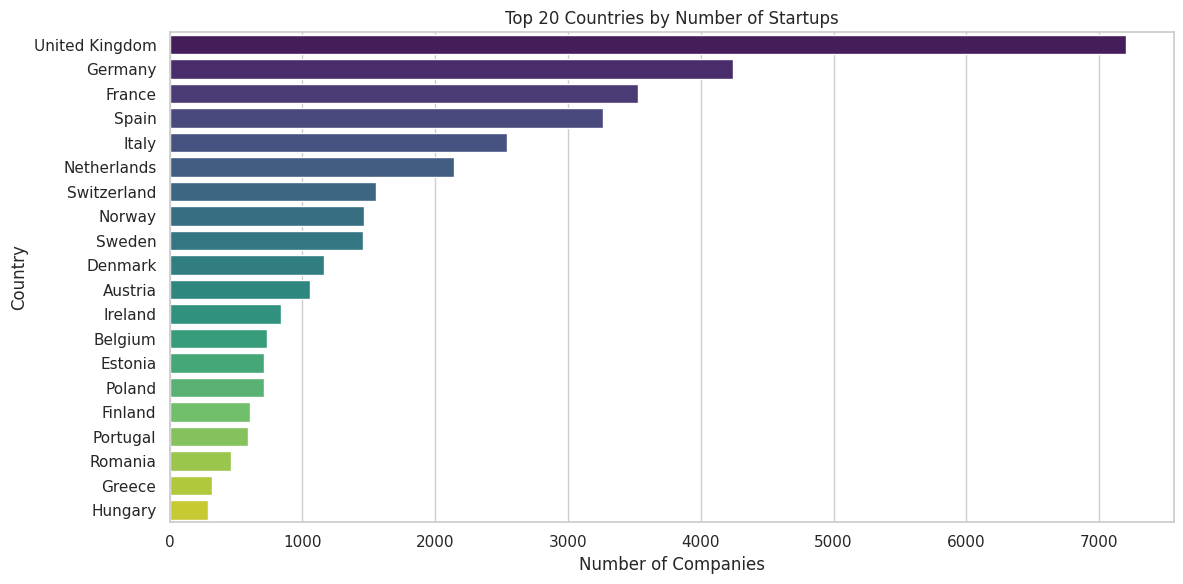

In [14]:
top_n = 20

plt.figure(figsize=(12, 6))
sns.barplot(
    data=country_counts.head(top_n),
    x="n_companies",
    y="country",
    palette="viridis"
)
plt.title(f"Top {top_n} Countries by Number of Startups")
plt.xlabel("Number of Companies")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

## Plot 5: Lifecycle Status Distribution by Country

<Figure size 1400x700 with 0 Axes>

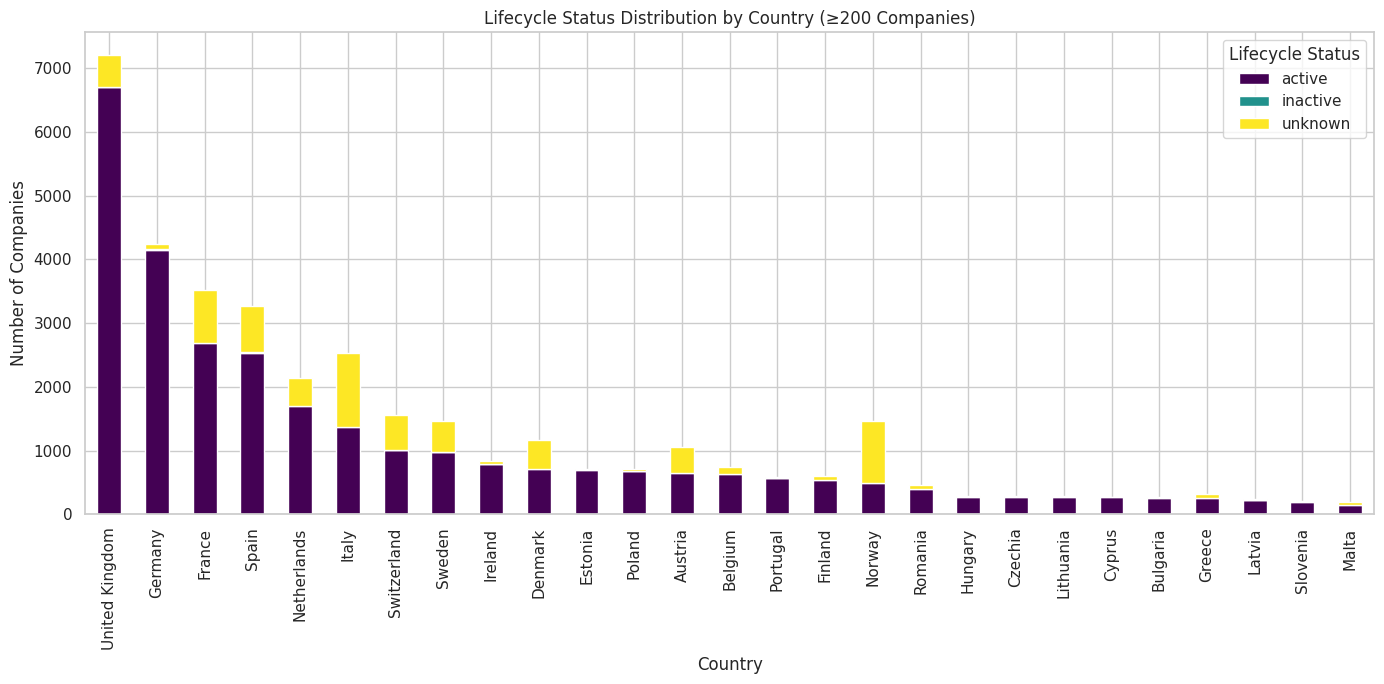

In [ ]:
# Count lifecycle statuses per country
country_lifecycle = (
    df_lifecycle
    .groupby(["country", "lifecycle_status"])
    .size()
    .reset_index(name="n")
)

country_lifecycle_pivot = country_lifecycle.pivot(
    index="country",
    columns="lifecycle_status",
    values="n"
).fillna(0)

filtered = country_lifecycle_pivot[
    country_lifecycle_pivot.sum(axis=1) >= 200
]

plt.figure(figsize=(14, 7))
filtered.sort_values("active", ascending=False)[["active", "inactive", "unknown"]].plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    colormap="viridis"
)

plt.title("Lifecycle Status Distribution by Country (≥200 Companies)")
plt.xlabel("Country")
plt.ylabel("Number of Companies")
plt.legend(title="Lifecycle Status")
plt.tight_layout()
plt.show()

## Plot 6: Active vs Inactive Startup Ratios by Country

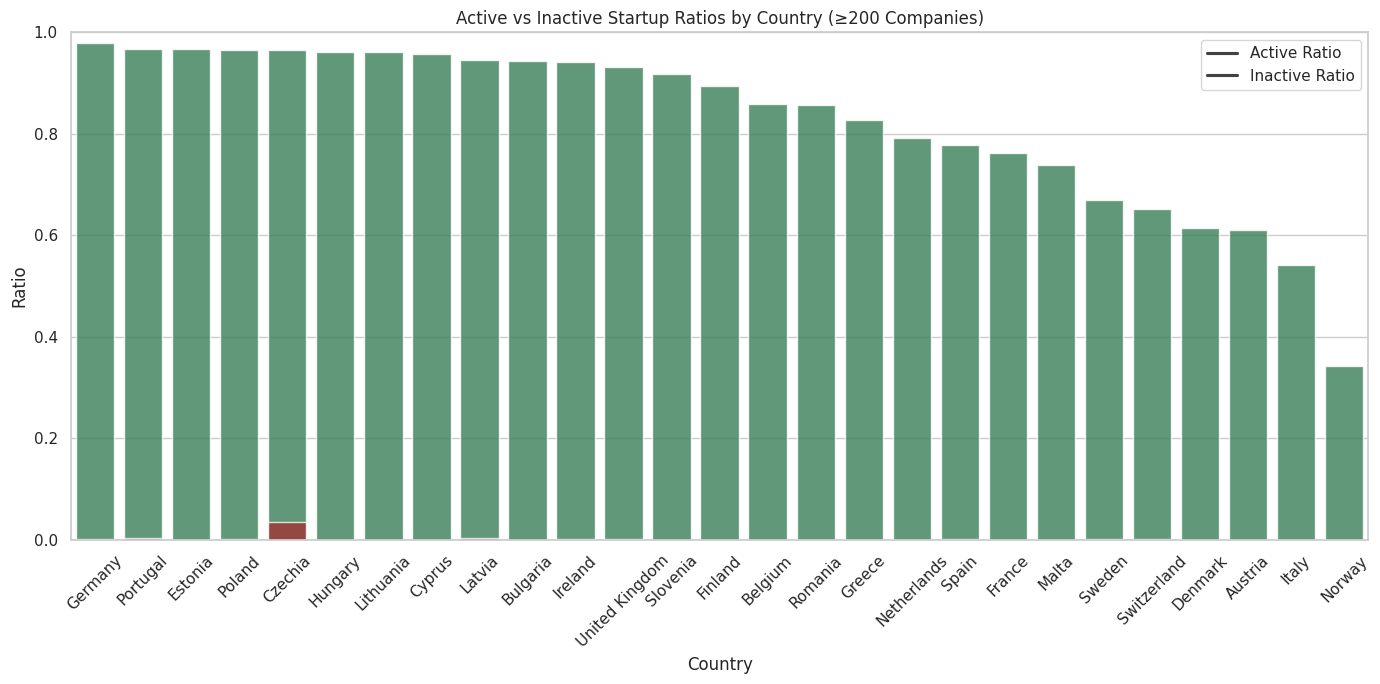

In [16]:
# Summaries per country
country_stats = (
    df_lifecycle
    .groupby("country")
    .agg(
        n_total=("company_id", "count"),
        n_active=("lifecycle_status", lambda x: (x == "active").sum()),
        n_inactive=("lifecycle_status", lambda x: (x == "inactive").sum())
    )
    .reset_index()
)

country_stats["active_ratio"] = country_stats["n_active"] / country_stats["n_total"]
country_stats["inactive_ratio"] = country_stats["n_inactive"] / country_stats["n_total"]

country_stats_filtered = country_stats[country_stats["n_total"] >= 200]

country_stats_sorted = country_stats_filtered.sort_values("active_ratio", ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(
    data=country_stats_sorted,
    x="country",
    y="active_ratio",
    color="seagreen",
    alpha=0.8
)
sns.barplot(
    data=country_stats_sorted,
    x="country",
    y="inactive_ratio",
    color="firebrick",
    alpha=0.8,
)

plt.title("Active vs Inactive Startup Ratios by Country (≥200 Companies)")
plt.ylabel("Ratio")
plt.xlabel("Country")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(["Active Ratio", "Inactive Ratio"])
plt.tight_layout()
plt.show()

1. Most European startups are young and early-stage

Age distribution peaks around 4–8 years, showing a highly youthful startup ecosystem.
Only a small tail stretches beyond 20–30 years, indicating that relatively few startups transition into long-term mature companies.

2. “Unknown” lifecycle companies are dramatically older

Active startups: Median age ≈ 6 years
Inactive startups: Median age ≈ 6 years
Unknown status startups: Median age ≈ 20 years

This suggests:

Many older companies pre-date modern startup databases.
Their lifecycle state is simply unreported, not necessarily inactive.

3. Funding strongly correlates with startup survival

Active startups have significantly higher funding counts and amounts.
Companies with no funding data are more likely to fall into the “unknown” or inactive categories.
Median funding for active startups is €0.75M, but the long tail shows the presence of heavily funded scale-ups.
Funding acts as both a signal and insurance policy:
higher funding → higher likelihood of continued operation.

4. Inactive startups are surprisingly small in number

Only 34 companies in the dataset are explicitly marked inactive.
Most failure cases are probably absorbed into the “unknown” group rather than flagged cleanly as shut down.
This reinforces the uneven quality of lifecycle reporting across Europe.

5. Geographic patterns reveal uneven startup survival

Countries with high startup density and strong ecosystems (Germany, Estonia, Portugal) show:
Very high active ratios (0.90+)
Very low inactive ratios

Countries with smaller or older company registries (Norway, Italy, Denmark) show:
Higher “unknown” or inactive proportions
Harder-to-track lifecycle reporting
Possibly older average company ages

The differences appear to reflect data completeness and ecosystem maturity, not necessarily real survival disparities